## Data files 

mofid_test.cvs/.json - normalized dictionary of MOFid

test.csv/.json - normalized all data (mofid, mofkey, space group, cell parameter, organic linker, metal node and etc.)

func.py - script for normalization raw data 

In [1]:
import pandas as pd 

# Import comet_ml at the top of your file
# from comet_ml import Experiment

import numpy as np
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## Data preparing 

In [2]:
# Import the dataset and split it into train and test
data = pd.read_csv('03_04_prepare.csv', index_col=0)
train_dataset, test_dataset = train_test_split(data, test_size=0.2)


In [3]:
train_dataset

,simples_nodes,simples_linkers,simples,topology,cat,a,b,c,alpha,beta,gamma,cell volume,space group
cifname,,,,,,,,,,,,,
7049949,0.041162,0.767442,0.766637,0.009050,0.000000,0.086149,0.075015,0.181297,0.515868,0.684300,0.480222,0.002926,0.054878
4341931,0.024213,0.533721,0.506655,0.004525,0.142857,0.098799,0.223769,0.086528,0.515868,0.546560,0.480222,0.004598,0.054878
7701228,0.963680,0.947674,0.945874,0.990950,0.000000,0.257777,0.257938,0.156084,0.515868,0.354983,1.000000,0.016472,0.963415
4130059,0.346247,0.073256,0.288376,0.429864,0.000000,0.215867,0.216037,0.164961,0.515868,0.354983,0.480222,0.014669,0.597561
4514000,0.048426,0.610465,0.590949,0.058824,0.000000,0.083055,0.179332,0.074062,0.515868,0.413872,0.480222,0.002991,0.048780
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4514511,0.038741,0.625581,0.606921,0.466063,0.000000,0.076518,0.157629,0.065631,0.515868,0.626449,0.480222,0.002124,0.054878
4305936,0.145278,0.426744,0.384206,0.058824,0.000000,0.051282,0.082292,0.084103,0.822042,0.597709,0.491484,0.000979,0.329268
4104063,0.159806,0.132558,0.112689,0.049774,0.000000,0.530691,0.530793,0.411361,0.515868,0.354983,0.480222,0.165505,0.317073


In [4]:
# Convert the data to tensors
train_dataset = tf.convert_to_tensor(train_dataset.to_numpy())
test_dataset = tf.convert_to_tensor(test_dataset.to_numpy())

## Variational autoencoder

In [5]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(13,)),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5, name = 'dropout1'),
            tf.keras.layers.Dense(32, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5, name = 'dropout2'),
            tf.keras.layers.Dense(latent_dim*2),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation=tf.nn.relu),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dense(13)
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [6]:
# What 
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# Compute loss function (in this case - ELBO)
def compute_loss(model, x):
  # Check input shape
  if len(x.shape) == 1:
    x = tf.expand_dims(x, axis=0)
  
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  x = tf.cast(x, dtype=tf.float32)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent)
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# Compute gradients and update parameters
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  # x = tf.expand_dims(x, axis=1)
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [7]:
# Introduce model and optimizer
latent_dim = 2
epochs = 50
model = CVAE(2)
optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
# Define the metrics
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')

# Store the losses for each epoch
train_elbo_history = []
test_elbo_history = []

for epoch in range(1, epochs + 1):
    start_time = time.time()

    # Training loop
    for train_x in train_dataset:
        train = tf.expand_dims(train_x, axis=0)
        train_loss = train_step(model, train, optimizer)
        train_loss_metric(train_loss)

    # Evaluation loop
    for test_x in test_dataset:
        test_loss = compute_loss(model, test_x)
        test_loss_metric(test_loss)

    end_time = time.time()
    
    # Calculate the ELBO
    train_elbo = -train_loss_metric.result()
    test_elbo = -test_loss_metric.result()

    # Print results
    print("\n" + "-" * 50)
    print(f'Epoch: {epoch}, Train ELBO: {train_elbo}, Test ELBO: {test_elbo}, time elapsed for current epoch: {end_time - start_time}')

    # Store the losses for each epoch
    train_elbo_history.append(train_elbo)
    test_elbo_history.append(test_elbo)
    
    # Reset metrics at the end of each epoch
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()


--------------------------------------------------
Epoch: 1, Train ELBO: -7.870939254760742, Test ELBO: -7.042689323425293, time elapsed for current epoch: 6.800448417663574

--------------------------------------------------
Epoch: 2, Train ELBO: -6.992342948913574, Test ELBO: -6.831752777099609, time elapsed for current epoch: 5.748099088668823

--------------------------------------------------
Epoch: 3, Train ELBO: -6.923438549041748, Test ELBO: -6.776889324188232, time elapsed for current epoch: 7.0260419845581055

--------------------------------------------------
Epoch: 4, Train ELBO: -6.886689186096191, Test ELBO: -6.724749565124512, time elapsed for current epoch: 6.2650465965271

--------------------------------------------------
Epoch: 5, Train ELBO: -6.8673505783081055, Test ELBO: -6.739346027374268, time elapsed for current epoch: 6.378045320510864

--------------------------------------------------
Epoch: 6, Train ELBO: -6.862061500549316, Test ELBO: -6.733288288116455, 

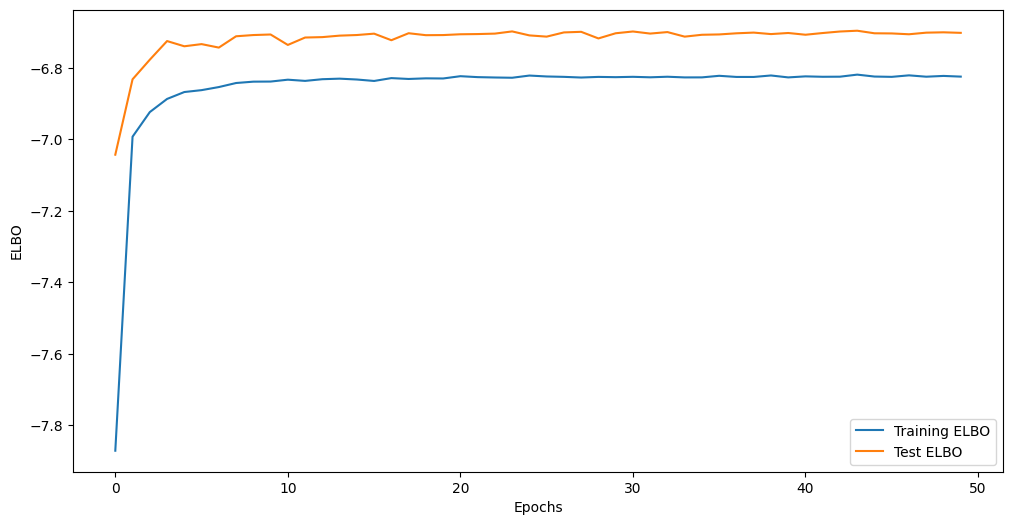

In [9]:
# Plot the ELBO for check overfitting
plt.figure(figsize=(12, 6))
plt.plot(train_elbo_history, label='Training ELBO')
plt.plot(test_elbo_history, label='Test ELBO')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.show()

In [10]:
# Grisha, we need to write the encryptor function from the data obtained at the output of the neuron after its training 

In [11]:
test = 1 